In [1]:
from IPython.display import Image
%matplotlib inline


In [8]:
!pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable


Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
You should consider upgrading via the 'C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\python.exe -m pip install --upgrade pip' command.


##  Preprocessing/Exploration/Inspection des valeurs

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
import os

In [44]:
data_dir = "./Class1_def"
#la dataset d image pour yosra

In [45]:
!pip install xmltodict
#installation de normes

Defaulting to user installation because normal site-packages is not writeable


Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
You should consider upgrading via the 'C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\python.exe -m pip install --upgrade pip' command.


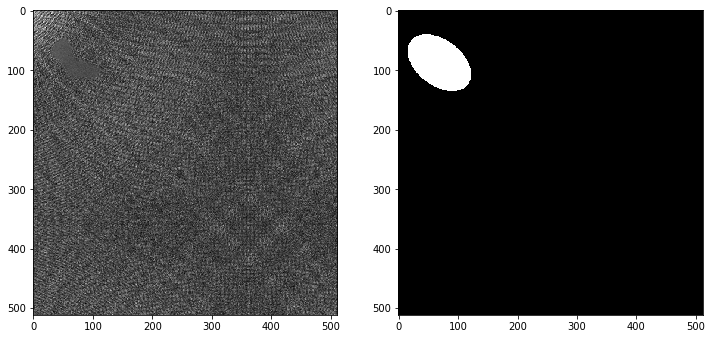

In [10]:
from coslib import plot_ellipse_seg_test

plot_ellipse_seg_test(os.path.join(data_dir, "1.png"))

In [11]:
from coslib import load_images_masks

In [12]:
X, y = load_images_masks(data_dir, img_type='png', img_format='gray', resize=(512, 512), ellipse=True)

In [13]:
X.shape

(150, 512, 512, 1)

In [14]:
y.shape

(150, 512, 512, 1)

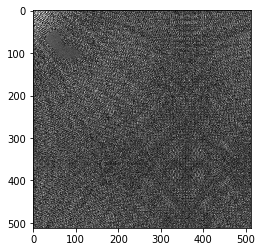

In [15]:
plt.imshow(X[0,:,:,0], cmap='gray')

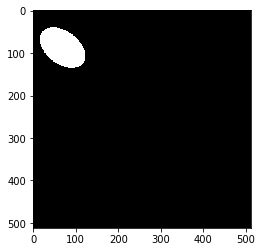

In [16]:
plt.imshow(y[0,:,:,0], cmap='gray')

In [17]:
import sklearn
from sklearn.model_selection import train_test_split

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [19]:
X_train.shape

(105, 512, 512, 1)

In [20]:
X_test.shape

(45, 512, 512, 1)

In [21]:
img_rows = 512
img_cols = 512

In [22]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Lambda, Conv2DTranspose, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as K
from scipy.ndimage.measurements import label
import time

In [23]:
# Defining a small Unet
# Smaller Unet defined so it fits in memory


def get_small_unet():
    inputs = Input((img_rows, img_cols, 1))
    inputs_norm = Lambda(lambda x: x/127.5 - 1.)
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(64, kernel_size=(
        2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(32, kernel_size=(
        2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(16, kernel_size=(
        2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(32, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(8, kernel_size=(
        2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(16, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=conv10)

    return model

In [24]:
model = get_small_unet()

In [25]:
def smooth_dice_coeff(smooth=1.):

    smooth = float(smooth)

    # IOU or dice coeff calculation
    def IOU_calc(y_true, y_pred):
            y_true_f = K.flatten(y_true)
            y_pred_f = K.flatten(y_pred)
            intersection = K.sum(y_true_f * y_pred_f)

            return 2*(intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

    def IOU_calc_loss(y_true, y_pred):
        return -IOU_calc(y_true, y_pred)
    return IOU_calc, IOU_calc_loss

IOU_calc, IOU_calc_loss = smooth_dice_coeff(0.00001)

In [26]:
model.compile(optimizer=Adam(lr=1e-4), loss=IOU_calc_loss, metrics=[IOU_calc])

In [24]:
history = model.fit(X_train, y_train, batch_size=10, epochs=50, verbose=1, validation_split=0.1)

Train on 94 samples, validate on 11 samples
Epoch 1/50
94/94 [==============================] - 21s 228ms/sample - loss: -0.0741 - IOU_calc: 0.0744 - val_loss: -0.0985 - val_IOU_calc: 0.1306
Epoch 2/50
94/94 [==============================] - 6s 66ms/sample - loss: -0.0785 - IOU_calc: 0.0787 - val_loss: -0.1046 - val_IOU_calc: 0.0873
Epoch 3/50
94/94 [==============================] - 6s 67ms/sample - loss: -0.0868 - IOU_calc: 0.0881 - val_loss: -0.1216 - val_IOU_calc: 0.1033
Epoch 4/50
94/94 [==============================] - 6s 67ms/sample - loss: -0.1164 - IOU_calc: 0.1191 - val_loss: -0.1912 - val_IOU_calc: 0.1949
Epoch 5/50
94/94 [==============================] - 6s 67ms/sample - loss: -0.2190 - IOU_calc: 0.2192 - val_loss: -0.2458 - val_IOU_calc: 0.2094
Epoch 6/50
94/94 [==============================] - 6s 66ms/sample - loss: -0.2868 - IOU_calc: 0.2862 - val_loss: -0.3206 - val_IOU_calc: 0.2969
Epoch 7/50
94/94 [==============================] - 6s 66ms/sample - loss: -0.3164 -

##  Courbe d'apprentissage

In [28]:
plt.figure(figsize=(20, 5))
plt.plot(model.history.history['loss'], label='Train loss')
plt.plot(model.history.history['val_loss'], label='Val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

AttributeError: 'NoneType' object has no attribute 'history'

<Figure size 1440x360 with 0 Axes>

In [29]:
plt.figure(figsize=(20, 5))
plt.plot(model.history.history['IOU_calc'], label='Train IOU')
plt.plot(model.history.history['val_IOU_calc'], label='Val IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()

AttributeError: 'NoneType' object has no attribute 'history'

<Figure size 1440x360 with 0 Axes>

## Predict on testing data

In [30]:
predict = model.predict(X_test)

In [31]:
import numpy as np
import cv2


def predict_evaluation(pred, image, label):
    '''
    '''
    # transform gray image to rgb
    img = np.array(image, np.uint8)
    rgb_img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    # scale pred and mask's pixel range to 0~255
    im_label = np.array(255*label, dtype=np.uint8)
    im_pred = np.array(255*pred, dtype=np.uint8)

    # transform both of them to rgb
    rgb_label = cv2.cvtColor(im_label, cv2.COLOR_GRAY2RGB)
    rgb_pred = cv2.cvtColor(im_pred, cv2.COLOR_GRAY2RGB)

    rgb_label[:, :, 1:3] = 0*rgb_label[:, :, 1:2]
    rgb_pred[:, :, 0] = 0*rgb_pred[:, :, 0]
    rgb_pred[:, :, 2] = 0*rgb_pred[:, :, 2]

    img_pred = cv2.addWeighted(rgb_img, 1, rgb_pred, 0.3, 0)
    img_label = cv2.addWeighted(rgb_img, 1, rgb_label, 0.3, 0)

    plt.figure(figsize=(10, 10))

    plt.subplot(1, 3, 1)
    plt.imshow(rgb_img)
    plt.title('Original image')
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(img_pred)
    plt.title('Prediction')
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(img_label)
    plt.title('Ground truth')
    plt.axis('off')

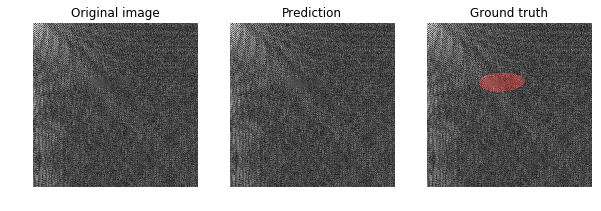

In [32]:
predict_evaluation(predict[0,:,:,0], X_test[0,:,:,0], y_test[0,:,:,0])

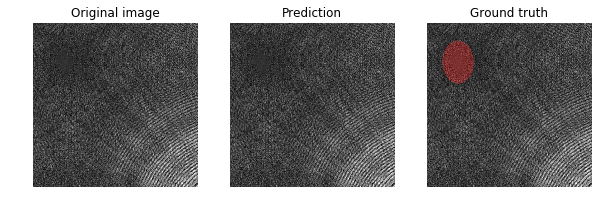

In [33]:
predict_evaluation(predict[1,:,:,0], X_test[1,:,:,0], y_test[1,:,:,0])

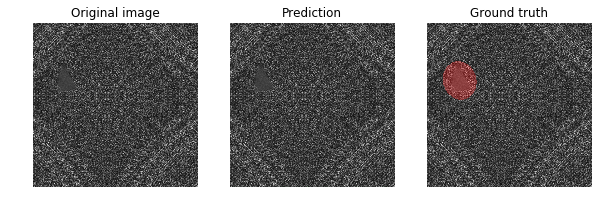

In [34]:
predict_evaluation(predict[2,:,:,0], X_test[2,:,:,0], y_test[2,:,:,0])

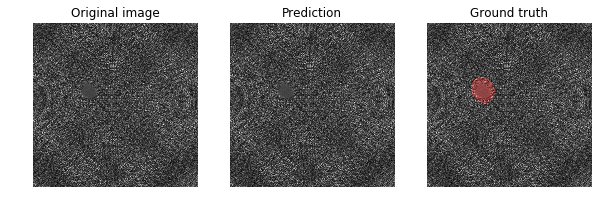

In [35]:
predict_evaluation(predict[3,:,:,0], X_test[3,:,:,0], y_test[3,:,:,0])

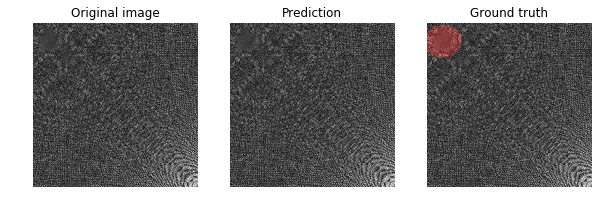

In [36]:
predict_evaluation(predict[4,:,:,0], X_test[4,:,:,0], y_test[4,:,:,0])

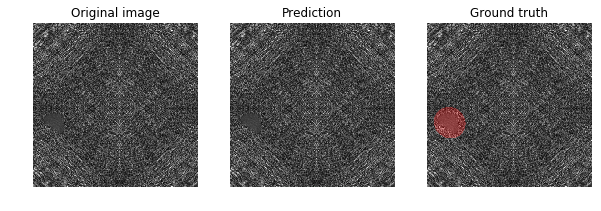

In [37]:
predict_evaluation(predict[5,:,:,0], X_test[5,:,:,0], y_test[5,:,:,0])

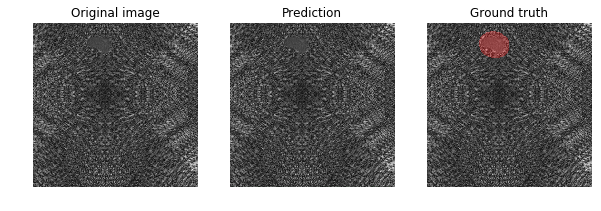

In [38]:
predict_evaluation(predict[6,:,:,0], X_test[6,:,:,0], y_test[6,:,:,0])

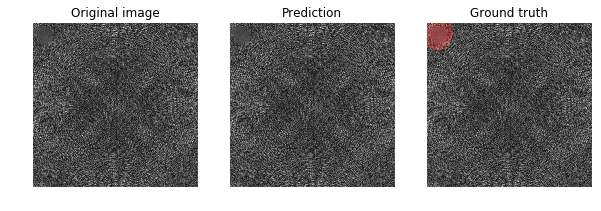

In [39]:
predict_evaluation(predict[7,:,:,0], X_test[7,:,:,0], y_test[7,:,:,0])

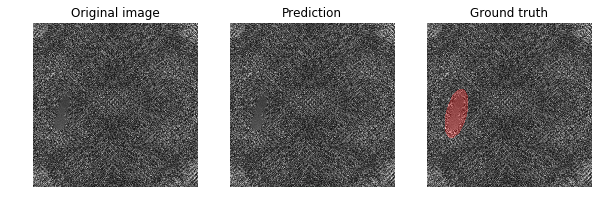

In [40]:
predict_evaluation(predict[8,:,:,0], X_test[8,:,:,0], y_test[8,:,:,0])

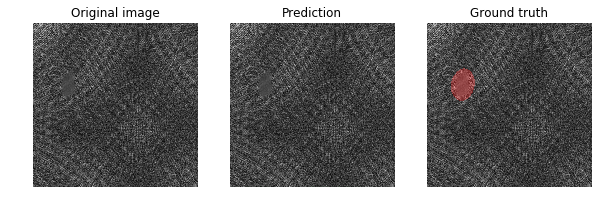

In [41]:
predict_evaluation(predict[9,:,:,0], X_test[9,:,:,0], y_test[9,:,:,0])

In [43]:
#probléme à signaler (chargement de l historique de learning)